Semi-Supervised Learning for Credit-Card Approval Project

Introduction: 
Dataset, that has been retrieved from remote server has over 90% of unlabeled data and 
at most 10% respectively. We need to predict labels of bad client for over 460000 samples, based on 
user personal information, provided. This Notebook prepares the dataset for the potential re-tranining by 
using semi-supervised learning technique

In [1051]:
# let's start by loading the dataset 
import pandas, numpy
import seaborn as sns 

applications = pandas.read_csv("application_record.csv")
credit_records = pandas.read_csv("credit_record.csv")

In [1052]:
applications

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [1053]:
credit_records

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [1054]:
# labeling data, presented in the credit records 

# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone_number",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)


Null Values handling (Application Records)

In [1055]:
applications.isnull().sum()

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone_number           0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [1056]:
missing_job = 'missing'
applications['job'].fillna(value=missing_job, inplace=True)

Null Values Handling (Credit Records)

In [1057]:
credit_records.isna().sum()

client_id        0
balance_month    0
due_status       0
dtype: int64

Handling outliers

In [1058]:
numeric_features = applications.select_dtypes(include='number').columns
numeric_features

Index(['client_id', 'total_children', 'annual_income', 'birthday',
       'days_employed', 'has_mobile_phone', 'has_work_phone',
       'has_phone_number', 'has_email', 'family_size'],
      dtype='object')

Total Children

<Axes: xlabel='total_children'>

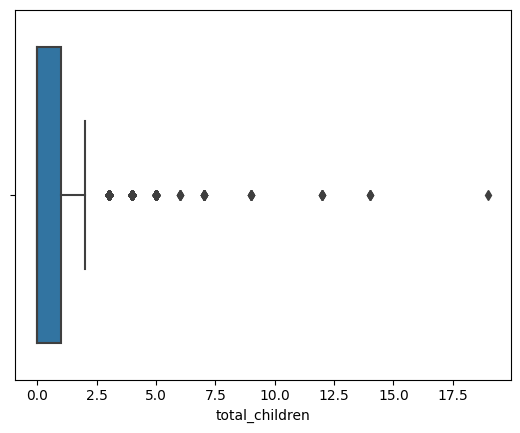

In [1059]:
sns.boxplot(x=applications['total_children'])

In [1060]:
low, high = numpy.percentile(applications['annual_income'], [25, 75])
iqr = (high - low)
low_fence, high_fence = low - (1.5 * iqr), high + (1.5 * iqr)

outliers = applications.loc[
    (applications["annual_income"] > high_fence) | (applications['annual_income'] < low_fence)
]


print('outliers: ', outliers.shape[0])
print('total samples: ', len(applications))



outliers:  19108
total samples:  438557


Family Size

<Axes: xlabel='family_size'>

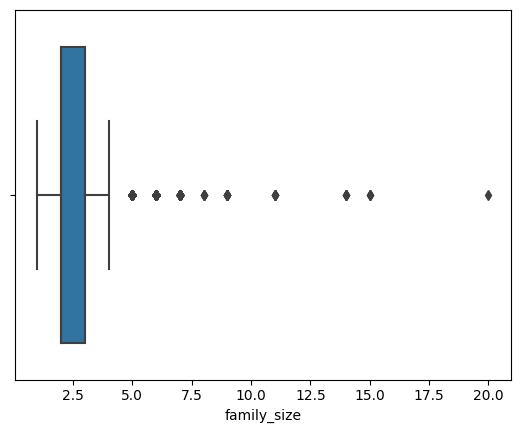

In [1061]:
sns.boxplot(x=applications['family_size'])

Feature Engineering

Application Record Features

In [1062]:
import math 

applications = applications.drop_duplicates(subset=["client_id"], keep='last', inplace=False)

applications['age'] = applications['birthday'].apply(lambda day: math.floor(abs(day) / 365))

applications['working_years'] = applications['days_employed'].apply(lambda days: math.floor(abs(days) // 365))

applications['employed'] = applications['days_employed'].apply(lambda days: True if days < 0 else False)

applications['emp_stability'] = applications['working_years'].apply(lambda years: True if years > 5 else False)

applications['has_children'] = applications['total_children'].apply(lambda children: True if children > 0 else False)

applications['owns_realty_and_car'] = numpy.where( 
    (applications['has_car'] == 'Y') & (applications['has_realty'] == 'Y'), True, False
)

applications['has_contact_information'] = numpy.where(
    (
        applications['has_email'] == 1
    ) 
    | (
        applications['has_phone_number'] == 1
    )
    | (
        applications['has_work_phone'] == 1
    ), True, False
)

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_37182/2332671203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications['age'] = applications['birthday'].apply(lambda day: math.floor(abs(day) / 365))
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_37182/2332671203.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications['working_years'] = applications['days_employed'].apply(lambda days: math.floor(abs(days) // 365))
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipy

In [1063]:
# Cleansing credit records dataset 
DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}
credit_records['due_status'] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[item])

Credit Record Features

In [1064]:
# introducing credit records features (bad client status)
credit_features = pandas.DataFrame()
credit_features['client_id'] = credit_records['client_id'].unique()
credit_features['overdues'] = pandas.Series(credit_records.groupby('client_id')['due_status'].sum().to_numpy())
credit_features['credit_window'] = numpy.abs(credit_records['balance_month'].min())
credit_features['overdue_perc'] = numpy.round(credit_features['overdues'] / credit_features['credit_window'], 2)

# annotating bad client status
credit_features['bad_client'] = numpy.where(credit_features['overdues'] > 0, True, False)
credit_features = credit_features[['client_id', 'credit_window', 'bad_client']]

Merging tables together

In [1065]:
merged_dataset = applications.merge(credit_features, on='client_id', how='inner')

<Axes: xlabel='annual_income'>

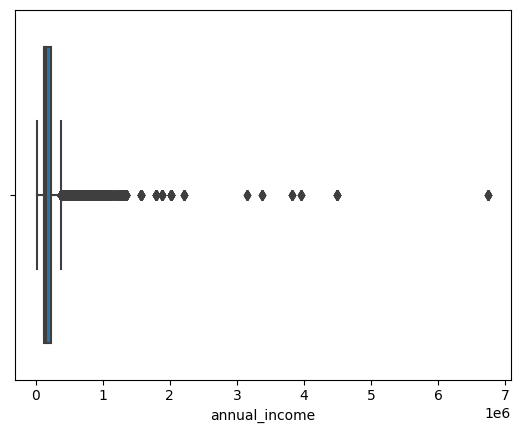

In [1066]:
sns.boxplot(x=applications['annual_income'])

In [1067]:
def remove_outliers_using_iqr(dataset: pandas.DataFrame, feature_name: str):
    """
    Function removes outliers using IQR Method
    """
    low, high = numpy.percentile(dataset[feature_name], [25, 75])
    iqr = (high - low)
    low_fence, high_fence = low - (1.5 * iqr), high + (1.5 * iqr)

    return dataset.loc[
    (dataset[feature_name] < high_fence) & (dataset[feature_name] > low_fence)
    ]

Dropping outliers

In [1068]:
merged_dataset = remove_outliers_using_iqr(merged_dataset, 'annual_income')

In [1069]:
merged_dataset = remove_outliers_using_iqr(merged_dataset, 'working_years')

Preparing dataset

In [1070]:
def encode_bool_features(dataset: pandas.DataFrame):
    """
    Function standardizes boolean features to the following format 
        True: (Y, 1)
        False: (N, 0)
    Args:
        dataset: pandas.DataFrame object, containing boolean features
    """
    bool_features = ['has_car', 'has_realty', 'has_phone_number', 'has_email', 'has_mobile_phone', 'has_work_phone']
    if not all(feature in dataset.columns for feature in bool_features): return 

    for feature in bool_features:
        dataset[feature] = dataset[feature].map(
            {
                'Y': True,
                'N': False,
                1: True,
                0: False
            }
        )

encode_bool_features(merged_dataset)

Dataset Splitting (training, testing)

In [1071]:
from sklearn.model_selection import train_test_split 

labeled_data = merged_dataset[merged_dataset['bad_client'].notnull()]
unlabeled_data = merged_dataset[merged_dataset['bad_client'].isnull()]

X_labeled = labeled_data.drop(columns=['bad_client'], inplace=False)
Y_labeled = labeled_data['bad_client']


x_train, x_test, y_train, y_test = train_test_split(
    X_labeled, Y_labeled, stratify=Y_labeled, test_size=0.45, random_state=42
)

training_set = pandas.concat([x_train, y_train], axis=1)
testing_set = pandas.concat([x_test, y_test], axis=1)

print(len(training_set), len(testing_set))

15786 12916


Standardizing data

In [1072]:
# before training models, we need to make sure, that numeric data falls in the same scales 
# otherwise some machine learning algorithms might end up having poor prediction ability 

from sklearn import preprocessing

def get_scaled_dataset(feature_dataset: pandas.DataFrame, scaler: preprocessing.StandardScaler=None) -> pandas.DataFrame:
    """
    Function scales numeric features using Standard Scaler 
    std = 1, mean = 0

    Args:
        feature_dataset: dataset for scaling
        scaler: Optional - pre-trained scaler if available
        
    Returns:
        dataset with scaled numeric data
    """
    numeric_features = feature_dataset.select_dtypes(include='number').columns
    other_features = feature_dataset.drop(columns=numeric_features, inplace=False).columns

    if scaler is None:
        scaler = preprocessing.StandardScaler()
        data = scaler.fit_transform(feature_dataset[numeric_features])
    else:
        data = scaler.transform(feature_dataset[numeric_features])

    df = pandas.DataFrame(data=data, columns=numeric_features, index=feature_dataset.index)
    
    return scaler, pandas.concat([df, feature_dataset[other_features]], axis=1)

In [1073]:
# scaler, training_set = get_scaled_dataset(training_set)
# _, testing_set = get_scaled_dataset(testing_set, scaler)

Feature Encoding

In [1074]:
from sklearn.preprocessing import OrdinalEncoder

def encode_living_place_feature(dataset: pandas.DataFrame):
    """
    Function encodes `living place` dataset using Ordinal Encoding 
    
    Args:
        dataset: pandas.DataFrame object, containing living_place feature
    """
    if not 'living_place' in dataset.columns: return 
    living_categories = [
        'Co-op apartment',
        'Office apartment',
        'Municipal apartment',
        'House / apartment',
        'Rented apartment', 
        'With parents',
    ]
    encoder = OrdinalEncoder(dtype=numpy.int8, categories=[living_categories])
    dataset['living_place'] = encoder.fit_transform(dataset[['living_place']])


def encode_income_category(feature_dataset: pandas.DataFrame):
    """
    Function encodes 'income_category' feature using One-Hot Encoding 

    Args:
        feature_data (pandas.Series) - feature
    
    Returns:
        dataset, containing new encoded feature
    """
    if not 'income_category' in feature_dataset: return 
    cats = [
        "Working",
        "State servant",
        "Pensioner",
        "Commercial associate",
        "Student"
    ]
    encoder = OrdinalEncoder(categories=[cats])
    feature_dataset['income_category'] = encoder.fit_transform(feature_dataset[['income_category']])

def encode_dataset(merged_dataset: pandas.DataFrame):
    """
    Encodes all feature dataset using appropriate
    feature encoding techniques 
    """
    encode_living_place_feature(merged_dataset)
    encode_income_category(merged_dataset)
    return merged_dataset

print(len(training_set), len(testing_set))

training_set = encode_dataset(training_set)
testing_set = encode_dataset(testing_set)


15786 12916


Removing Redundant and Unncessesary Features

In [1075]:
# Removing features, what do not have logical sense / not considered in the process


for dataset in [
    training_set, testing_set, unlabeled_data
]:
    dataset.drop(
        columns=[
            'birthday', 
            'days_employed', 
            'total_children',
            'has_realty',
            'has_car',
            'family_status',
            'gender',
            "client_id",
            "job",
            'has_work_phone',
            'family_size',
            'has_phone_number',
            'has_mobile_phone',
            'has_email',
            'education_category',
            'income_category',
        ], inplace=True
    )

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_37182/2708063972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(


Datatypes Assigning

In [1076]:
def set_datatypes(df):
    # Numeric Data
    df['annual_income'] = df['annual_income'].astype(numpy.int64)
    df['age'] = df['age'].astype(numpy.int8)

    # Boolean Data
    df['working_years'] = df['working_years'].astype(numpy.int8)

    # Categorical Data
    df['living_place'] = df['living_place'].astype(numpy.int8)
    df['bad_client'] = df['bad_client'].astype(numpy.bool_)

set_datatypes(training_set)
set_datatypes(testing_set)

In [1077]:
training_set.isna().sum()

annual_income              0
living_place               0
age                        0
working_years              0
employed                   0
emp_stability              0
has_children               0
owns_realty_and_car        0
has_contact_information    0
credit_window              0
bad_client                 0
dtype: int64

Class Imbalance Fix

In [1078]:
from imblearn.over_sampling import SMOTE 

x_data, y_data = training_set.drop(columns=['bad_client']), training_set['bad_client']

def balance_dataset(X_data: pandas.DataFrame, Y_data: pandas.Series):
    """
    Function uses SMOTE (Sensitivity Class Over Sampling Technique) to address class imbalance issue
    
    Args:
        X_data: pandas.DataFrame object containing independent features
        Y_data: pandas.Series object representing target variable
    """
    encoder = SMOTE(k_neighbors=5, random_state=42)
    x_res, y_res = encoder.fit_resample(X=X_data, y=Y_data)
    return pandas.concat([x_res, y_res], axis=1)


# training_set = balance_dataset(X_data=x_data, Y_data=y_data)

In [1079]:
f = training_set[training_set['bad_client'] == False]
s = training_set[training_set['bad_client'] == True]

f['has_children'].value_counts()

has_children
False    9852
True     5673
Name: count, dtype: int64

Checking balance

<Axes: xlabel='bad_client', ylabel='count'>

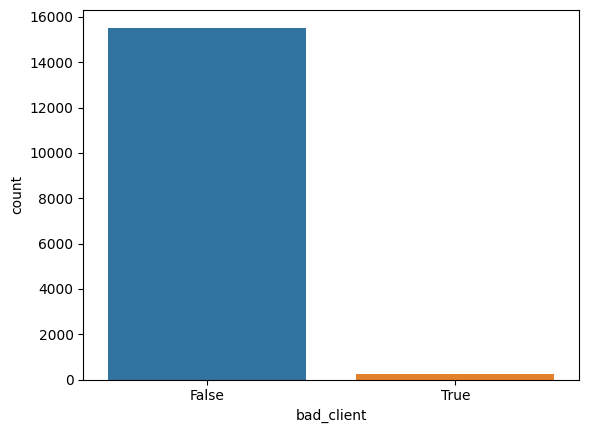

In [1080]:
sns.countplot(data=training_set, x='bad_client')

<Axes: >

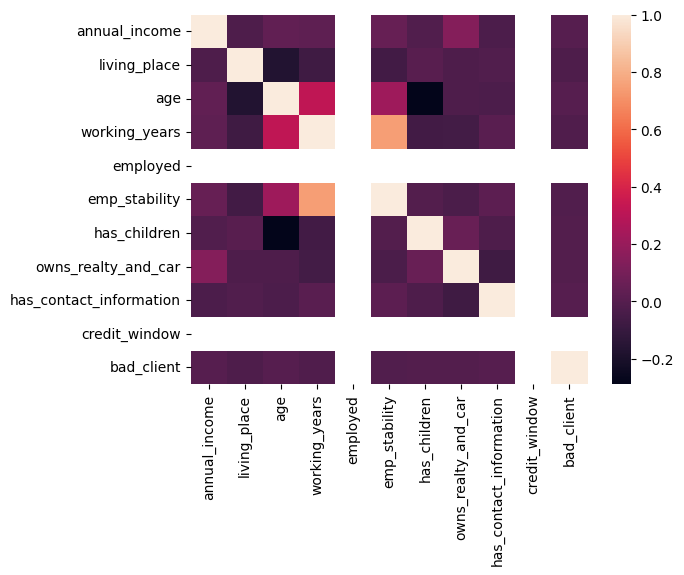

In [1081]:
sns.heatmap(training_set.corr())

<Axes: >

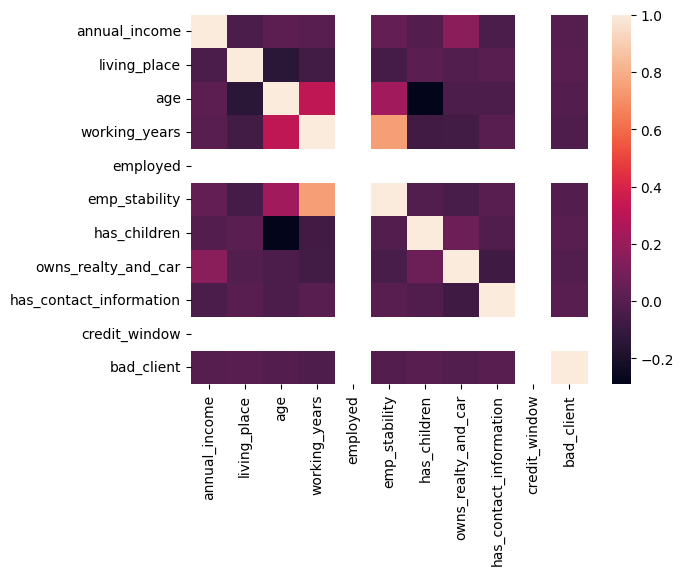

In [1082]:
sns.heatmap(testing_set.corr())

In [1083]:
training_set['bad_client'].value_counts()

bad_client
False    15525
True       261
Name: count, dtype: int64

In [1084]:
testing_set['bad_client'].value_counts()

bad_client
False    12703
True       213
Name: count, dtype: int64

In [1085]:
print(len(training_set), len(testing_set))

15786 12916


Saving new datasets to a CSV Files

In [1086]:
training_set.to_csv("training_set.csv")
testing_set.to_csv('testing_set.csv')

In [1087]:
training_set.columns

Index(['annual_income', 'living_place', 'age', 'working_years', 'employed',
       'emp_stability', 'has_children', 'owns_realty_and_car',
       'has_contact_information', 'credit_window', 'bad_client'],
      dtype='object')